# Check (That Tweet) Yo Self 
## Prioritizing Tweets to Fact Check
###### Part 3A: Tweet EDA
In this notebook, we'll explore the tweets we've gathered and cleaned.

Imports:

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import warnings
import regex as re
import seaborn as sns
import re
import statistics

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from nltk.sentiment.vader import SentimentIntensityAnalyzer
warnings.filterwarnings('ignore')
np.random.seed(824)
from bs4 import BeautifulSoup 

# Import stopwords.
from nltk.corpus import stopwords # Import the stopword list
import nltk


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

Reading in our data:

In [39]:
tweet = pd.read_csv('../data/cleaned_with_lysol.csv')

In [40]:
tweet.head(2)

,id,time,author,author_id,associated_tweet,text,links,hashtags,mentions,reply_count,...,hashtag_count,mention_count,word_count,char_count,link_count,text_sentiment,text_links_removed,clean_text,clean_word_count,clean_char_count
0,1254198473819291649,2020-04-25 16:59:52,PulpNews,100986964,1254198473819291649,Isolation and boredom of staying at home can b...,['https://t.co/49b7W0d6V5'],[''],[''],0,...,0,0,25,238,1,-0.6124,Isolation and boredom of staying at home can b...,isolation boredom staying home harmful way doc...,11,64
1,1254198461563637763,2020-04-25 16:59:49,aishacs,15809934,1254197958595301386,We left the trail early once we saw that the s...,[],[''],[''],2,...,0,0,46,253,0,-0.2960,We left the trail early once we saw that the s...,left trail early saw sentiment shifted worried...,24,156


Function to view the distribution of a feature:

In [42]:
def view_dist (df, column):
    return (plt.figure(figsize= (8,6)), 
            sns.distplot(df[column], 
                         bins=10, kde = True), 
            plt.title(f'Distribution of {column}'))

(<Figure size 576x432 with 1 Axes>,
 Text(0.5, 1.0, 'Distribution of not_english'))

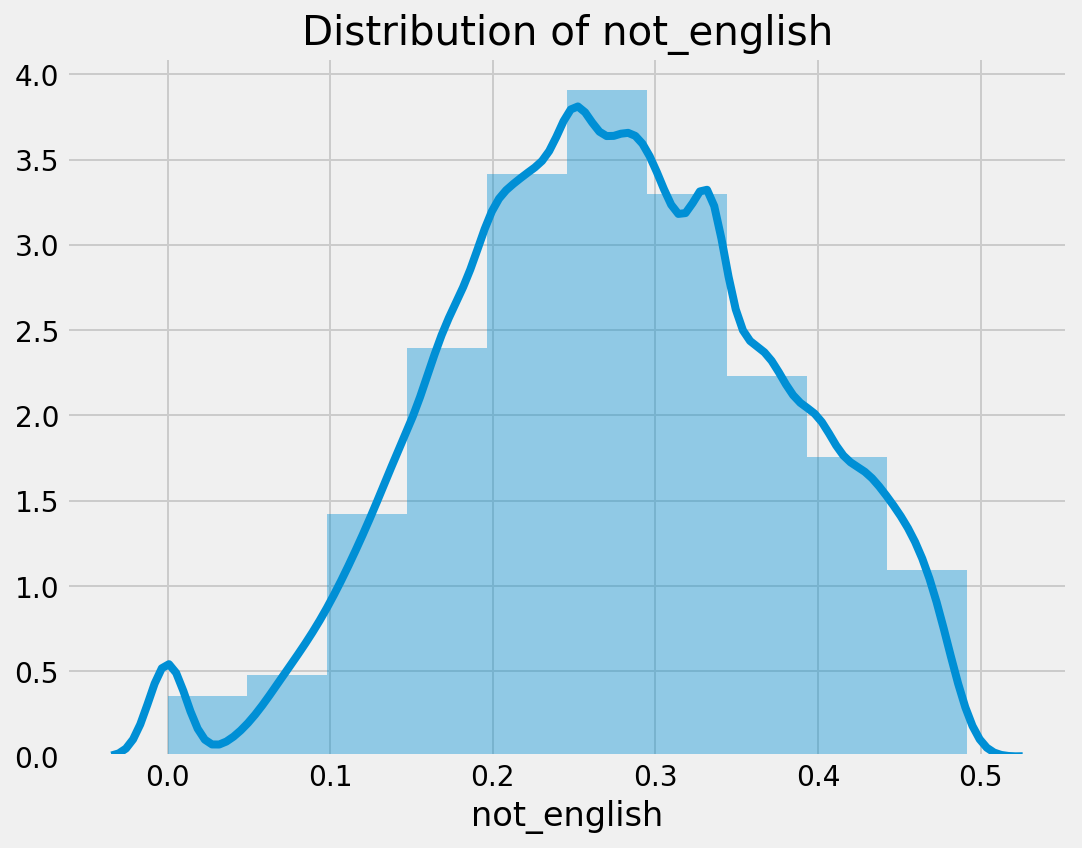

In [43]:
view_dist(tweet, 'not_english')

Since we removed anyting over 50% (with the idea that this would filter out most non-english tweets), the remaining distribution is interesting. Many words, like even our keywords of "COVID" / "coronavirus", did not register as English. It looks like most words have a quarter of non-english (or not in the official english dictionary) words in them.

(<Figure size 576x432 with 1 Axes>,
 Text(0.5, 1.0, 'Distribution of text_sentiment'))

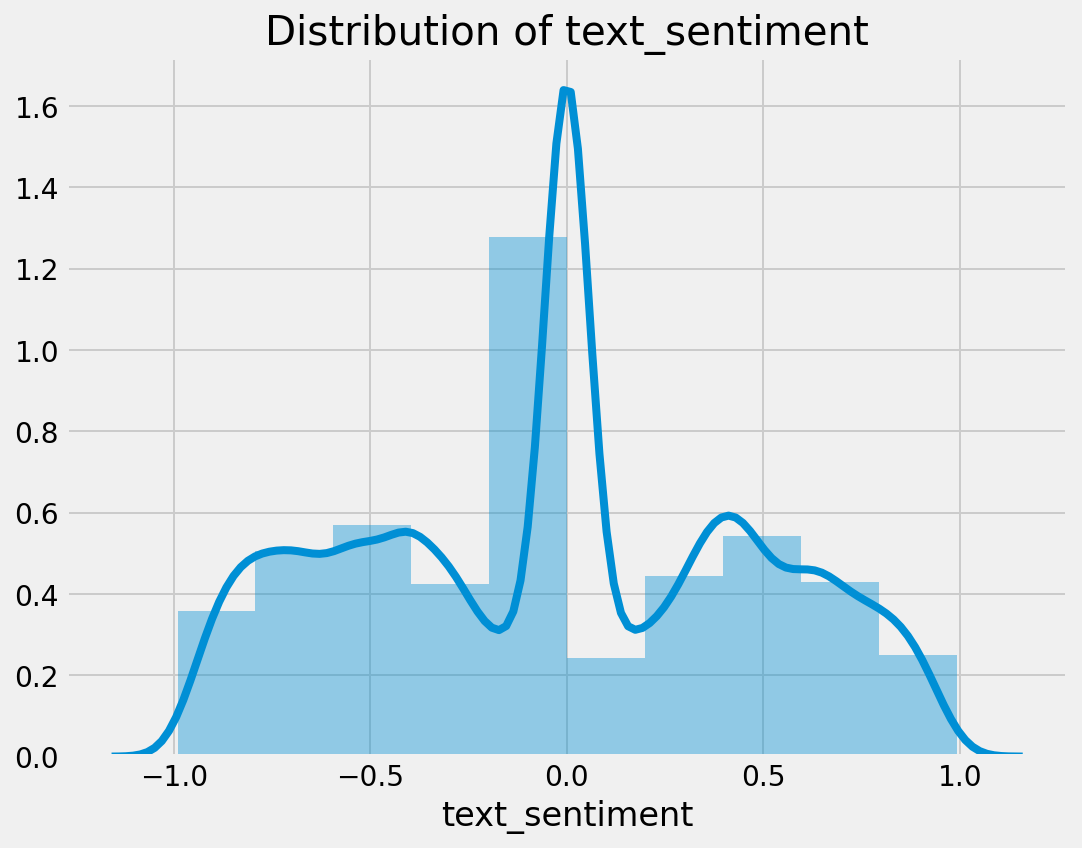

In [44]:
view_dist(tweet, 'text_sentiment')

The average sentiment of our tweets is just under 0 but is somewhat normally distributed.

(<Figure size 576x432 with 1 Axes>,
 Text(0.5, 1.0, 'Distribution of word_count'))

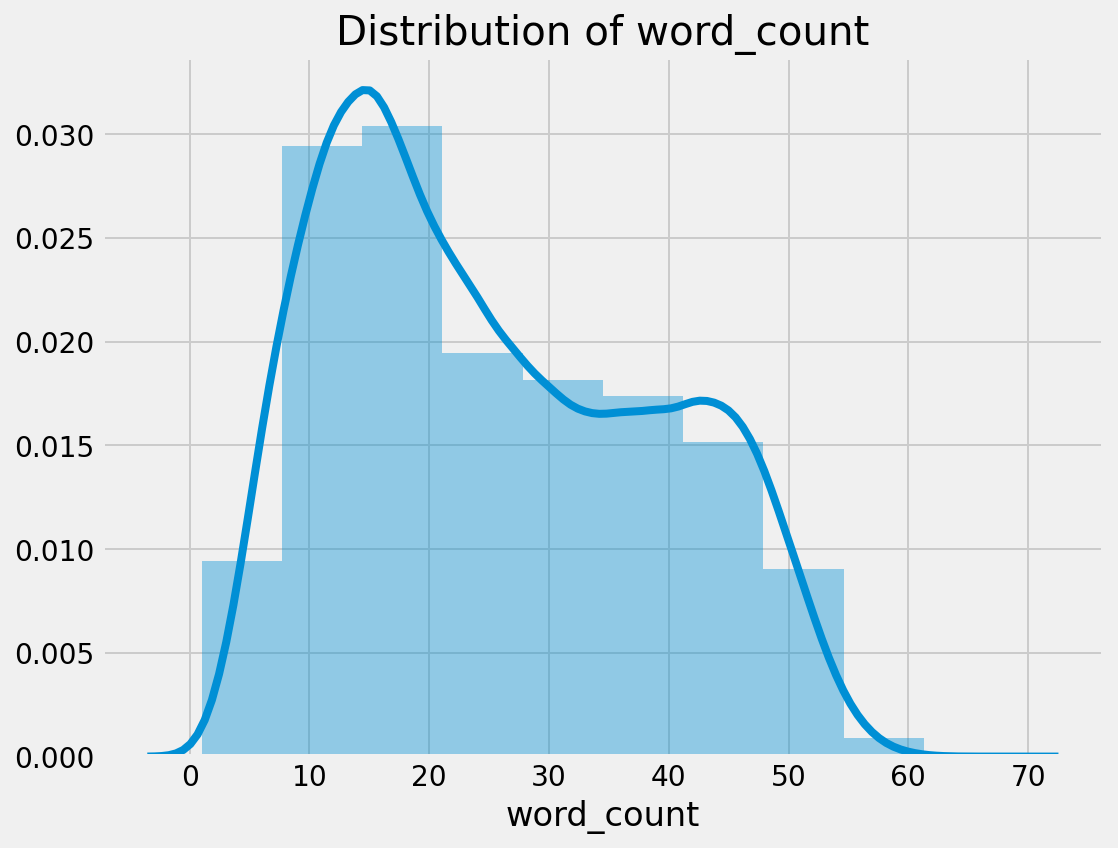

In [45]:
view_dist(tweet, 'word_count')

Word count is slightly right skewed, most tweets have around 15 words.

(<Figure size 576x432 with 1 Axes>,
 Text(0.5, 1.0, 'Distribution of clean_word_count'))

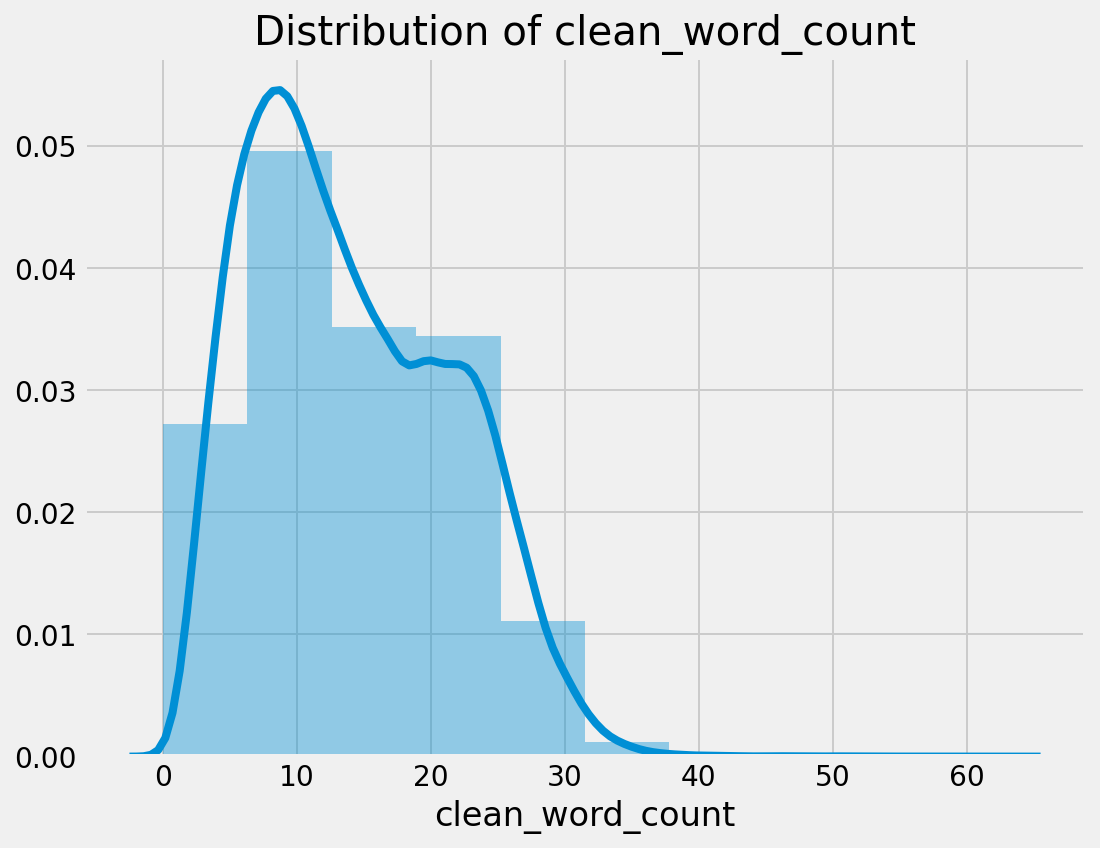

In [46]:
view_dist(tweet, 'clean_word_count')

Likewise, once the stopwords have been cleaned out, the center of the distribution moves down but still slightly right skewed.

(<Figure size 576x432 with 1 Axes>,
 Text(0.5, 1.0, 'Distribution of char_count'))

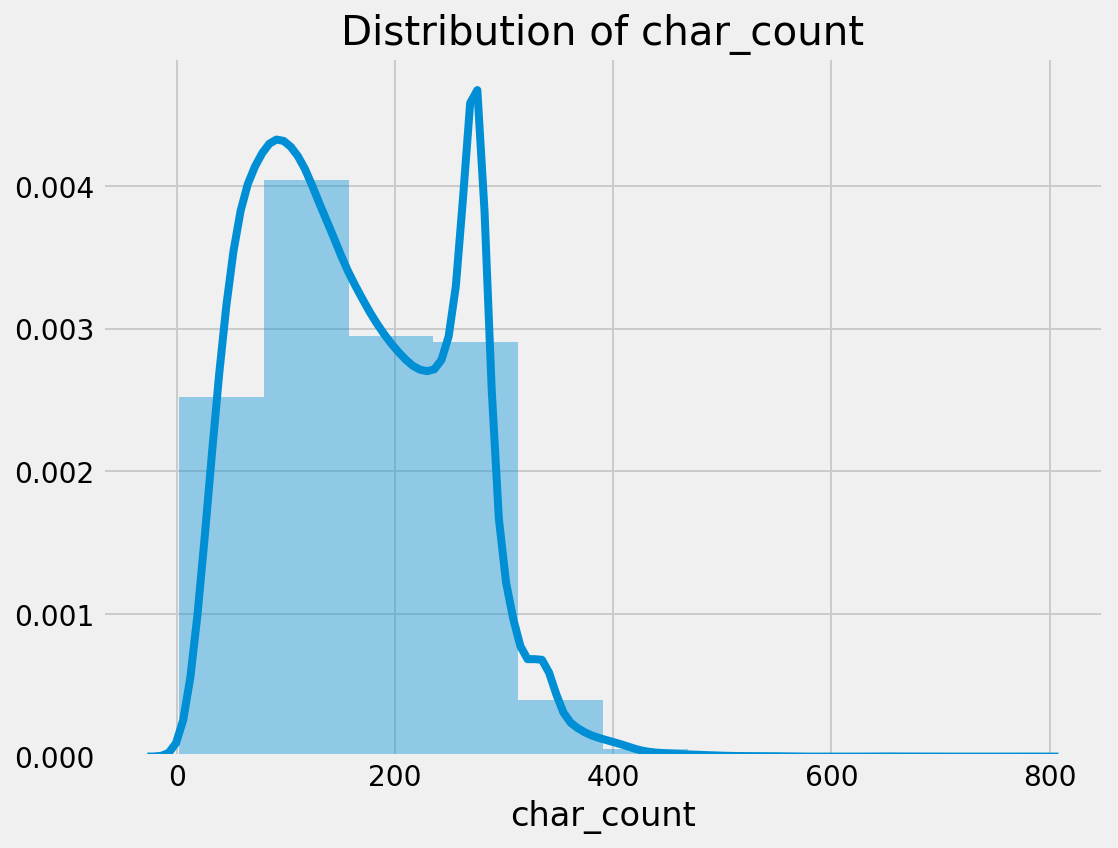

In [47]:
view_dist(tweet, 'char_count')

It makes sense that the character count looks mostly normally distributed because of the limit on Twitter.

(<Figure size 576x432 with 1 Axes>,
 Text(0.5, 1.0, 'Distribution of clean_char_count'))

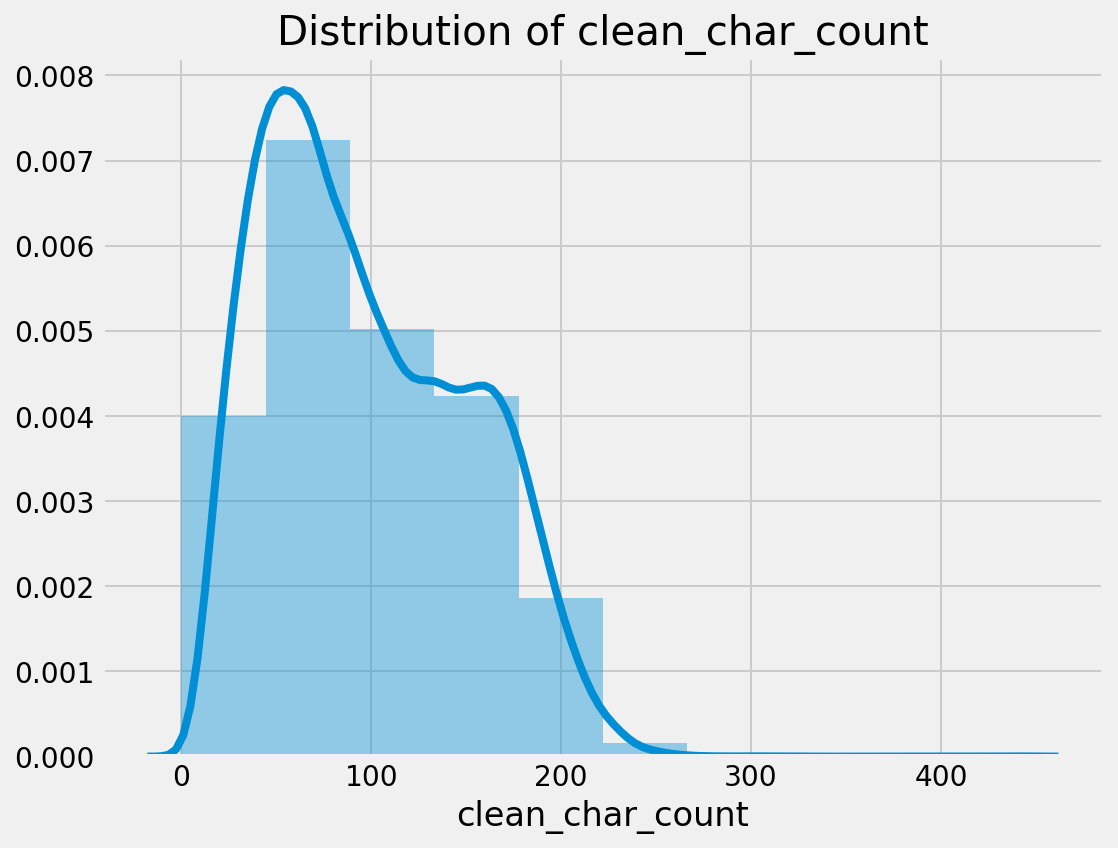

In [48]:
view_dist(tweet, 'clean_char_count')

Again, once cleaned up, the center of our distribution decreases.

(<Figure size 576x432 with 1 Axes>,
 Text(0.5, 1.0, 'Distribution of hashtag_count'))

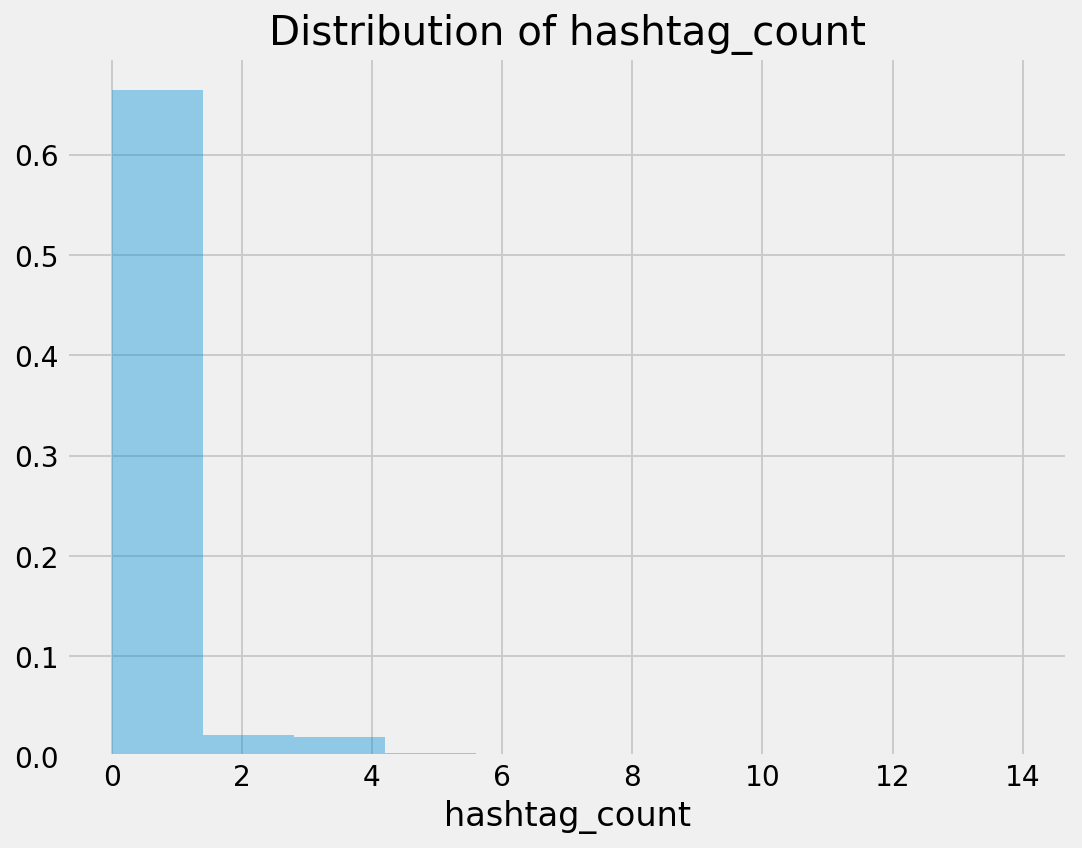

In [49]:
view_dist(tweet, 'hashtag_count')

This graph shows how few hashtags most users use. Many use none.

(<Figure size 576x432 with 1 Axes>,
 Text(0.5, 1.0, 'Distribution of mention_count'))

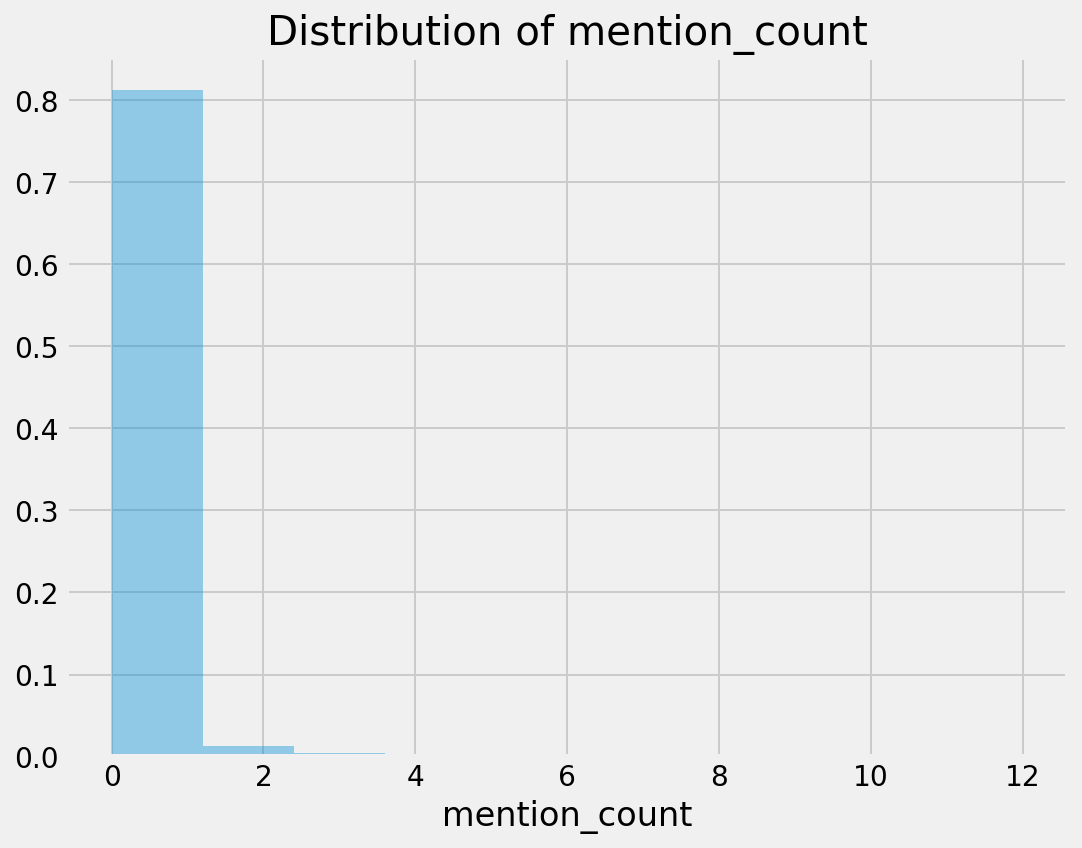

In [50]:
view_dist(tweet, 'mention_count')

Similar to hashtags, most tweets to not mention anyone although there are outliers that mention a lot of other accounts.

(<Figure size 576x432 with 1 Axes>,
 Text(0.5, 1.0, 'Distribution of link_count'))

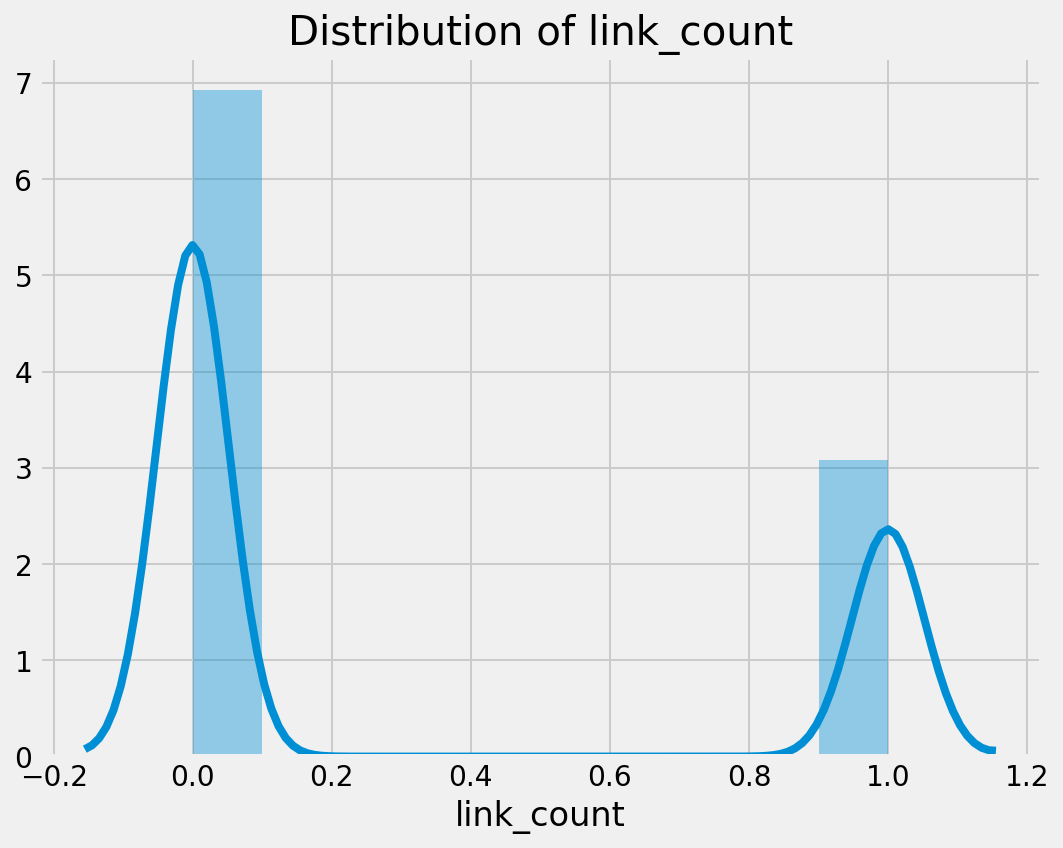

In [51]:
view_dist(tweet, 'link_count')

More users tweet without links but about a third include. Links are common when sharing newsarticles or pictures.

(<Figure size 576x432 with 1 Axes>,
 Text(0.5, 1.0, 'Distribution of reply_count'))

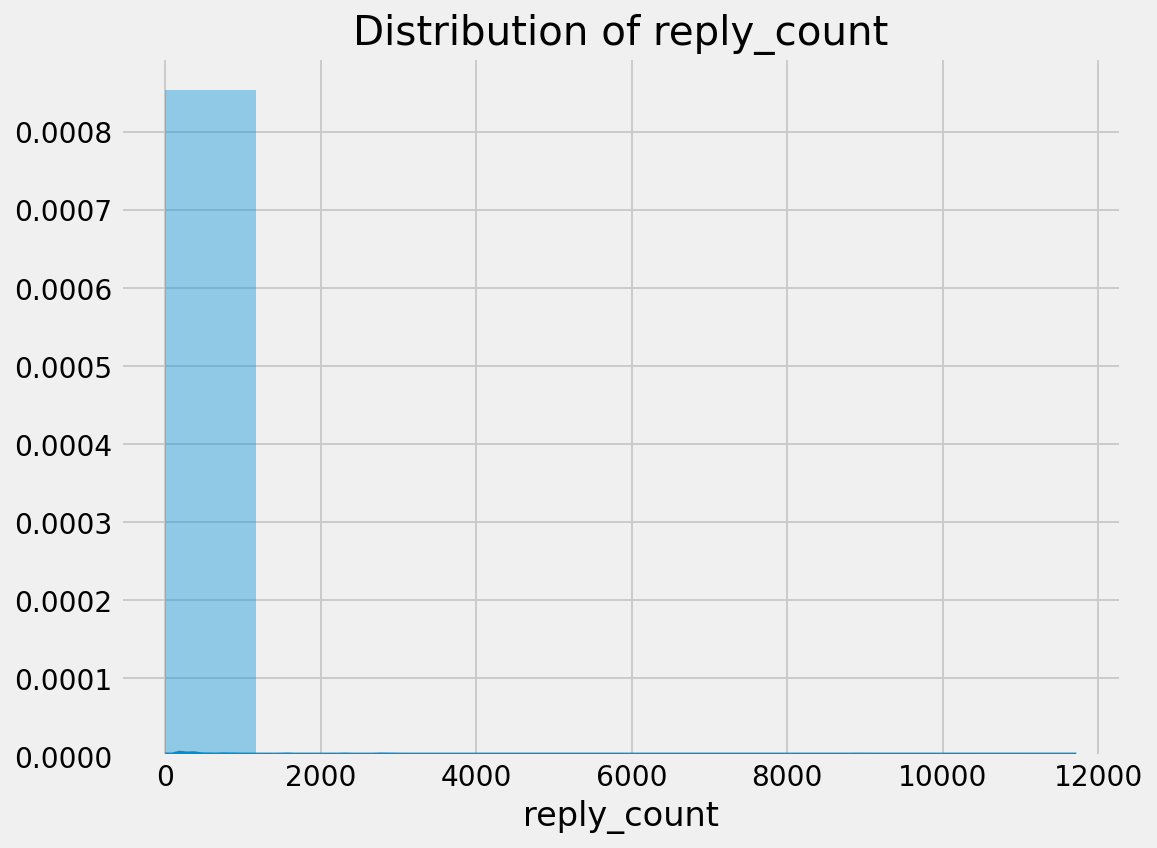

In [52]:
view_dist(tweet, 'reply_count')

The vast majority of tweets get few replies but there are outliers that take off and have a lot of replies.

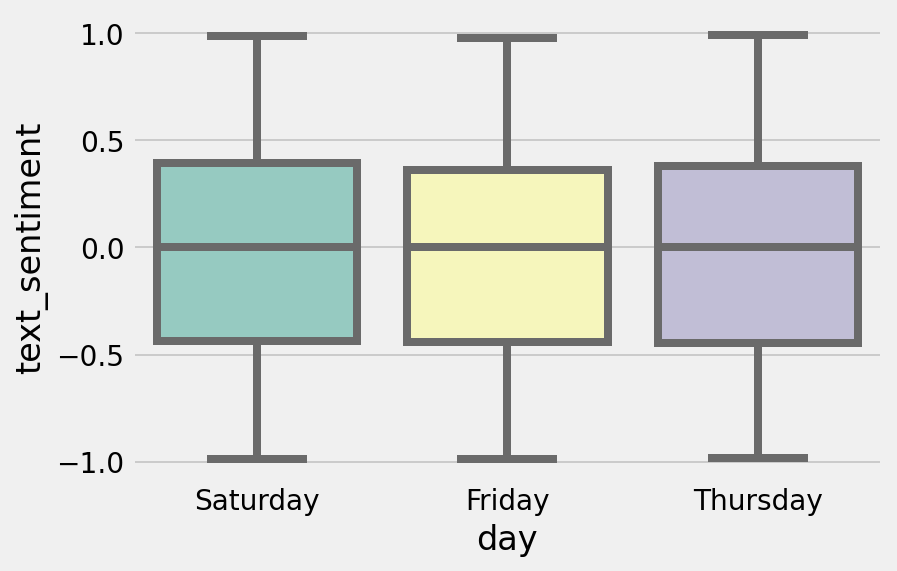

In [58]:
sns.boxplot(x="day", 
            y="text_sentiment", 
            #hue="link_count",
            data=tweet, 
            palette="Set3")

The boxplots above so there isn't much difference in text sentiment between the days.

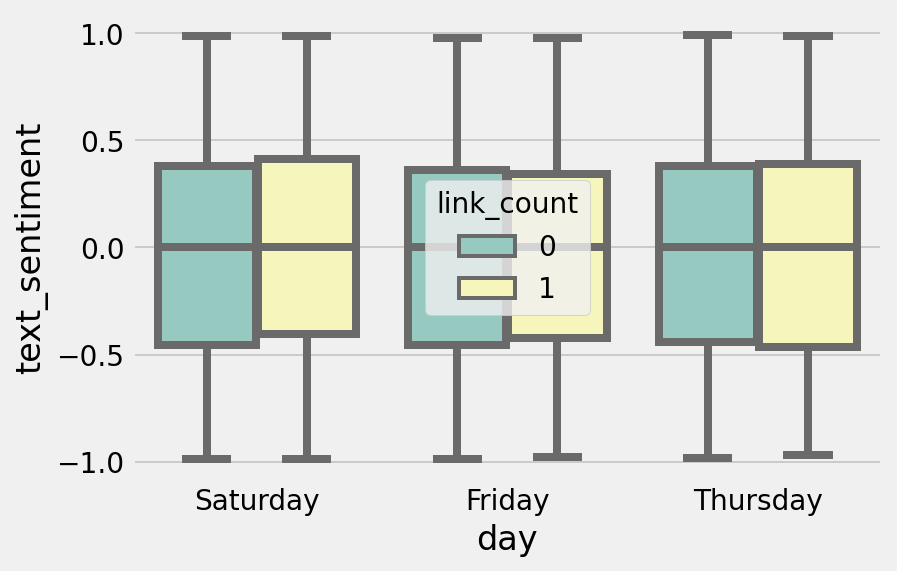

In [59]:
sns.boxplot(x="day", 
            y="text_sentiment", 
            hue="link_count",
            data=tweet, 
            palette="Set3")

The same goes for tweets with and without links, the sentiment average doesn't vary between the days.

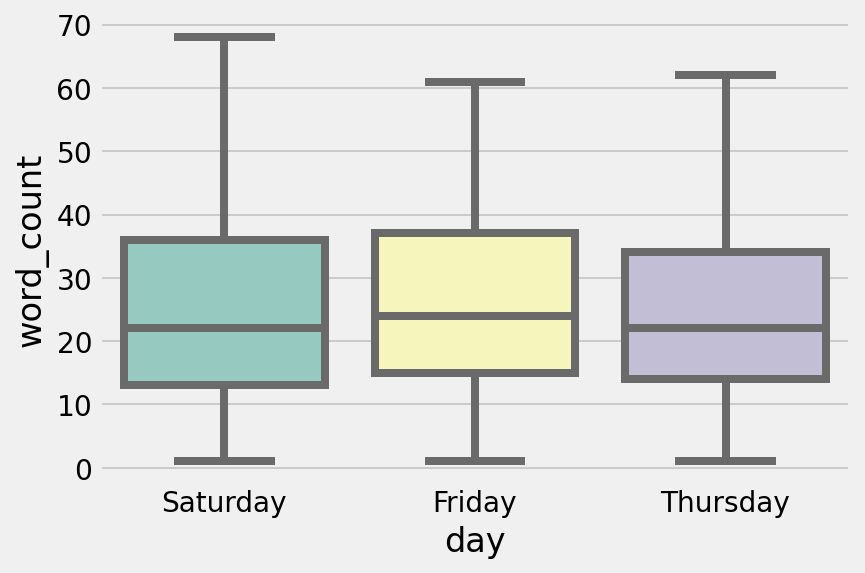

In [60]:
sns.boxplot(x="day", 
            y="word_count", 
            #hue="word_count",
            data=tweet, 
            palette="Set3")

Word count is slightly higher on Friday but Saturday has a wider range.

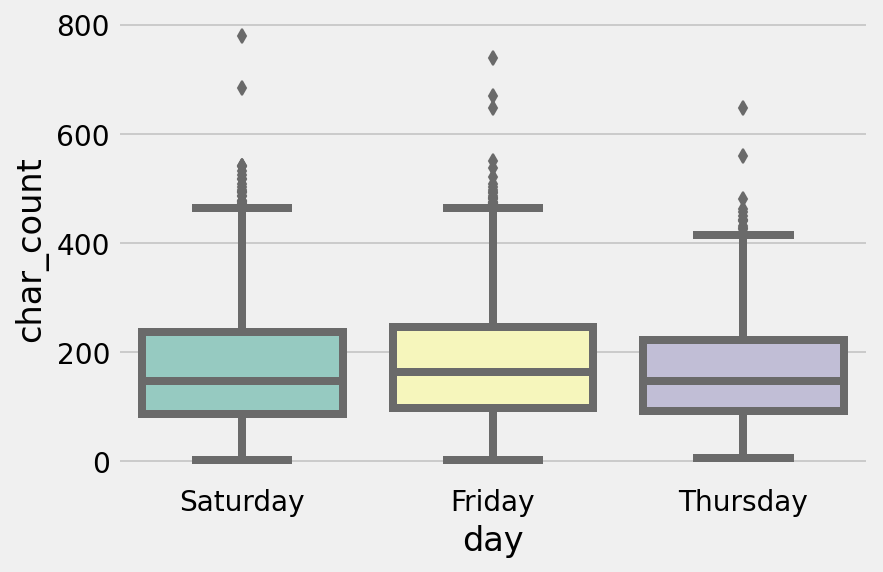

In [61]:
sns.boxplot(x="day", 
            y="char_count", 
            #hue="word_count",
            data=tweet, 
            palette="Set3")

In keeping with the trend above, Friday also has a slightly higher media charactr count.

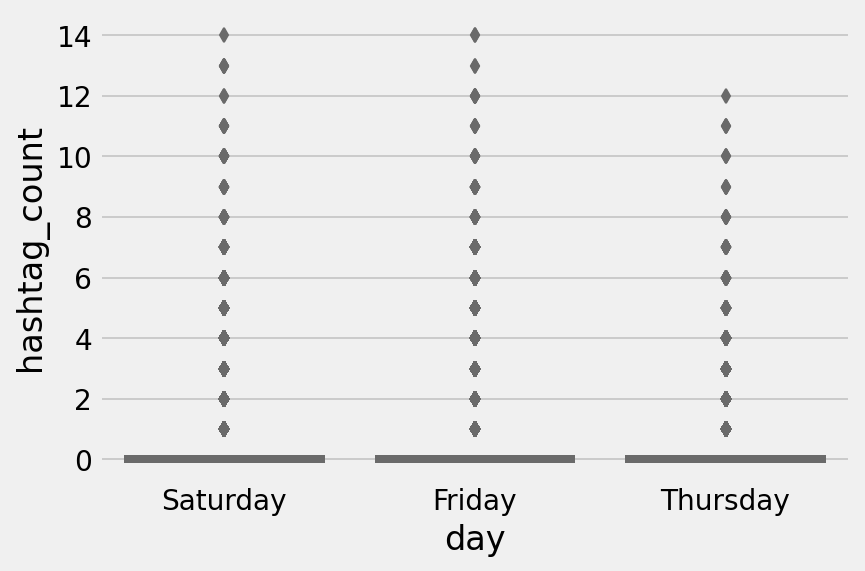

In [62]:
sns.boxplot(x="day", 
            y="hashtag_count", 
            data=tweet, 
            palette="Set3")

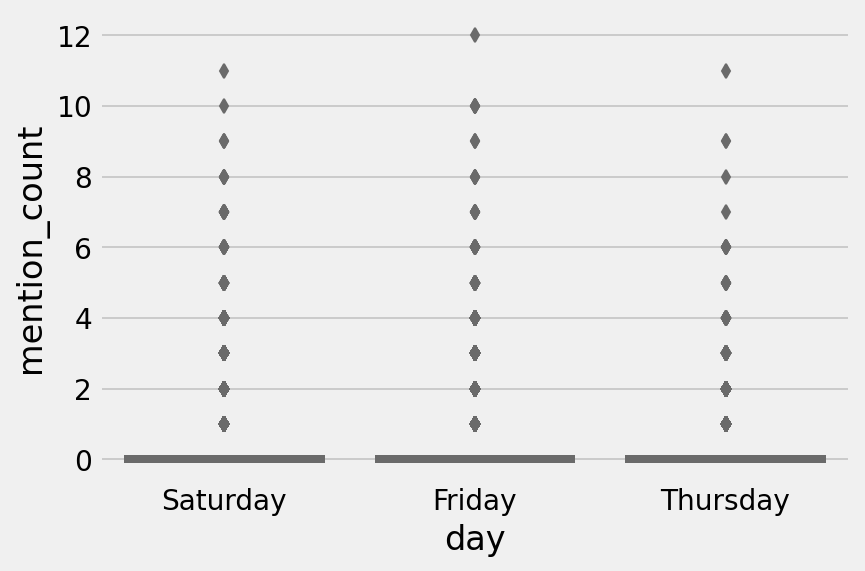

In [63]:
sns.boxplot(x="day", 
            y="mention_count", 
            data=tweet, 
            palette="Set3")

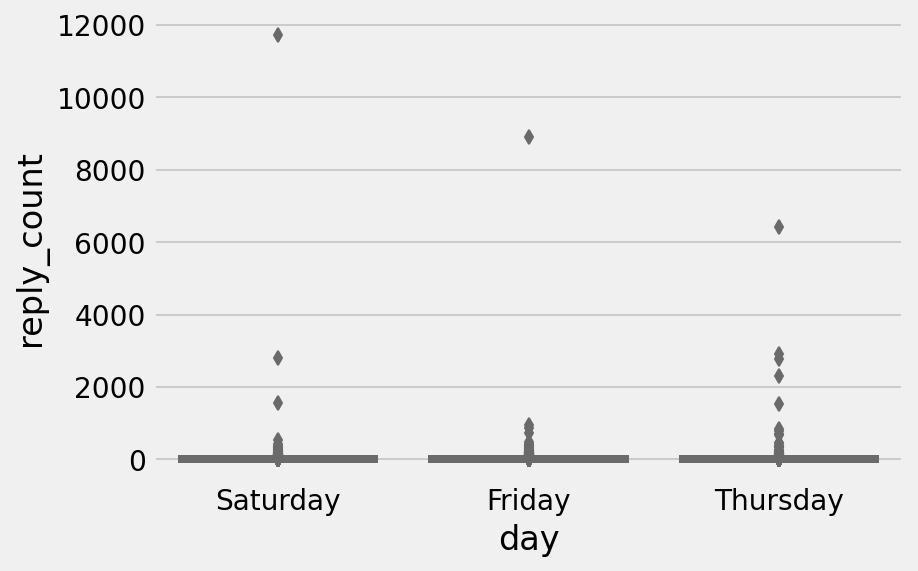

In [64]:
sns.boxplot(x="day", 
            y="reply_count", 
            #hue="word_count",
            data=tweet, 
            palette="Set3")

These boxplots reflect what we saw in our histograms, most users don't use hashtags or metions and get very few replies but there are really extreme outliers for all these categories